In [433]:
import pandas as pd
import nltk
import regex as re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe

import time
RANDOM_SEED = 85213

In [922]:
df = pd.read_csv('./data/tweets.csv')

In [916]:
df2 = pd.read_csv('./data/tweets.csv')

In [568]:
df2

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# EDA

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [117]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [994]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5532
Positive emotion                      2970
Negative emotion                       569
Name: target, dtype: int64

This shows a big imbalance in the number of positive and negative sentiments, and also shows the majority of it having no opinion.<br />
We're joining the 'I cant't tell' column with the 'No emotion' one.

In [923]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 'No emotion toward brand or product' if  x == "I can't tell" else x)

In [120]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [924]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Getting rid of the one instance of empty tweet:

In [197]:
df.dropna(subset=['tweet_text'], inplace=True)

Getting rid of duplicates:

In [198]:
df.duplicated().sum()

22

In [925]:
df.drop_duplicates(inplace=True)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Renaming columns for easier understanding:

In [926]:
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'target'}, inplace=True)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9070 non-null   object
 1   product  3282 non-null   object
 2   target   9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Creating a length feature:

# Modeling

## Train-Test Split

In [976]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, stratify=y)

In [977]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [978]:
def label(df):
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2,
                                     'I can\'t tell': 0})
    return df

In [979]:
def clean_function(df):
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'@\S*', '', x))
    return df

In [980]:
# def remove_non_ascii(text):
#     return unidecode(unicode(text, encoding = "utf-8"))

In [981]:
def tokenize(df):
    df['text'] = df['text'].apply(lambda x: re.split("\W+",x) )
    return df

In [982]:
def remove_punctuation(df):
    df['text'] = df['text'].apply(lambda x: [''.join(letter for letter in word if letter not in string.punctuation) for word in x])
    df['text'] = df['text'].apply(lambda x: [word for word in x if word])
    return df

In [983]:
def remove_stopwords(df):
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopword])
    return df

In [984]:
# def lem(df):
#     df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x]).apply(lambda x: ' '.join(x))
#     return df

In [985]:
def join_cleaned_data(df):
    df['text'] = df['text'].apply(lambda x: ' '.join(x))
    return df

In [986]:
cleaning_pipeline = Pipeline(steps=[
    ('label', FunctionTransformer(label)),
    ('clean', FunctionTransformer(clean_function)),
    ('token', FunctionTransformer(tokenize)),
    ('remove_punctuation', FunctionTransformer(remove_punctuation)),
    ('remove_stopwords', FunctionTransformer(remove_stopwords)),
    ('join_cleaned_data', FunctionTransformer(join_cleaned_data))
])

In [987]:
df_test

,text,target
4340,Hmm. RT @mention We interrupt your regularly s...,No emotion toward brand or product
1199,how about this: will be LATE RT @mention Googl...,No emotion toward brand or product
1351,Z8: First ZLF assignment! {link} [codes valid:...,No emotion toward brand or product
7925,Apple sets up temporary Austin store to serve ...,Positive emotion
7764,#SXSW ?? RT @mention Google to Launch Major Ne...,No emotion toward brand or product
...,...,...
5210,RT @mention #Apple pop up store at #sxsw selli...,No emotion toward brand or product
1934,@mention Alive and loving it! Great talks from...,Positive emotion
8245,Better get in line now. RT @mention Apple is o...,Positive emotion
7207,Google should do a Doodle for #SXSW.,No emotion toward brand or product


In [988]:
df_train

,text,target
4288,Look for me at sxsw. I'm the bearded guy in pl...,No emotion toward brand or product
1336,What's up with this &quot;pop-up Apple store&q...,No emotion toward brand or product
1862,@mention about to talk at #sxsw on mistakes bu...,Negative emotion
454,���@mention DownloadFREE tracks from the #SXSW...,No emotion toward brand or product
5665,RT @mention Designing for the iPad? Catch @men...,No emotion toward brand or product
...,...,...
5383,RT @mention all: @mention recorded a cover exc...,No emotion toward brand or product
5321,RT @mention #sxsw WAZE {link} is duking it out...,Negative emotion
1044,���@mention RT @mention Google to Launch Major...,No emotion toward brand or product
4144,Barry Diller: will not do an iPad-only newspap...,No emotion toward brand or product


In [991]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [992]:
df_test_clean

,text,target
5448,apple opening pop store austin sixth amp congr...,0
3477,hey come fast company grille hungry mention za...,0
8386,ipad hipster austincrowd sxsw link,0
7925,apple sets temporary austin store serve hordes...,2
2180,gdgtaustin attendees havin fun happy sxsw stop...,0
...,...,...
8910,sxswi google says future location location loc...,0
1934,alive loving great talks jonathan dahl minimal...,2
8245,better get line apple opening temp store downt...,2
4065,24 hours later retreat back hotel bushwhacked ...,0


In [998]:
X_train_clean = df_train_clean['text']
y_train_clean = df_train_clean['target']

In [999]:
mnb = Pipeline([('cv', CountVectorizer(lowercase=False)),
               ('mnb', MultinomialNB())])

lr = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [1000]:
models = [('MultiNomBa', mnb),
          ('LogisticReg', lr),
          ('DecTreeClass', dtc),
          ('RandomFor', rf),
          ('GradBoost', gbc),
          ('SupportVec', svc)]

In [1001]:
def fit_models(models, X, y):
    '''
    Inputs a list of (name, model)
    Fits data into models
    '''
    for name, model in models:
        model.fit(X, y)
    return None

In [1002]:
def cross_validate_models(models, X, y, cv=5, scoring='accuracy', cm=False):
    fit_models(models, X_train_clean, y_train_clean)
    results = [(name, cross_validate(model, X_train_clean, y_train_clean, scoring=scoring, cv=cv)) for name, model, in models]
    scores = [(result[0], result[1]['test_score'].mean()) for result in results]
    if cm==True:
        for model in models:
             print_cm_with_labels(y_train_clean, model[1].predict(X_train_clean), display_labels)
    return scores

In [1003]:
scores = cross_validate_models(models, X_train_clean, y_train_clean, cm=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [686]:
scores

[('MultiNomBa', 0.6792114362276871),
 ('LogisticReg', 0.6931767299131261),
 ('DecTreeClass', 0.6455474996758439),
 ('RandomFor', 0.6853859618792411),
 ('GradBoost', 0.6690670787051044),
 ('SupportVec', 0.6975886026710464)]

In [687]:
mnb_tf = Pipeline([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('mnb', MultinomialNB())])

lr_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [688]:
models2 = [('MultiNomBa', mnb_tf),
          ('LogisticReg', lr_tf),
          ('DecTreeClass', dtc_tf),           
          ('RandomFor', rf_tf),
          ('GradBoost', gbc_tf),
          ('SupportVec', svc_tf)]

In [689]:
scores2 = cross_validate_models(models2, X_train_clean, y_train_clean)

In [690]:
scores2

[('MultiNomBa', 0.6612754462549163),
 ('LogisticReg', 0.6942062497298699),
 ('DecTreeClass', 0.6304014133206552),
 ('RandomFor', 0.6834731166529802),
 ('GradBoost', 0.6687728530060078),
 ('SupportVec', 0.6964116998746597)]

In [692]:
mnb_sm = imbpipe([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
                ('smote', SMOTE(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [693]:
models3 = [('MultiNomBa', mnb_sm),
          ('LogisticReg', lr_sm),
          ('DecTreeClass', dtc_sm),
          ('RandomFor', rf_sm),
          ('GradBoost', gbc_sm),
          ('SupportVec', svc_sm)]

In [694]:
scores3 = cross_validate_models(models3, X_train_clean, y_train_clean)

In [695]:
scores3

[('MultiNomBa', 0.5982048234429701),
 ('LogisticReg', 0.6602467908544756),
 ('DecTreeClass', 0.617903898517526),
 ('RandomFor', 0.674947810865713),
 ('GradBoost', 0.6276117258071487),
 ('SupportVec', 0.6886208237887367)]

In [696]:
mnb_ros = imbpipe([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [697]:
models4 = [('MultiNomBa', mnb_ros),
          ('LogisticReg', lr_ros),
          ('DecTreeClass', dtc_ros),
          ('RandomFor', rf_ros),
          ('GradBoost', gbc_ros),
          ('SupportVec', svc_ros)]

In [698]:
scores4 = cross_validate_models(models4, X_train_clean, y_train_clean)

In [699]:
scores4

[('MultiNomBa', 0.6082008255175693),
 ('LogisticReg', 0.6624492155422051),
 ('DecTreeClass', 0.6012940312054285),
 ('RandomFor', 0.6715659981847258),
 ('GradBoost', 0.5535176340925789),
 ('SupportVec', 0.6881789990059213)]

In [700]:
mnb_gr = imbpipe([('Vectorizer',  TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (2,3), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [701]:
models5 = [('MultiNomBa', mnb_gr),
          ('LogisticReg', lr_gr),
          ('DecTreeClass', dtc_gr),
          ('RandomFor', rf_gr),
          ('GradBoost', gbc_gr),
          ('SupportVec', svc_gr)]

In [996]:
scores5 = cross_validate_models(models5, X_train_clean, y_train_clean, cm=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [703]:
scores5

[('MultiNomBa', 0.6145253273976747),
 ('LogisticReg', 0.6562769589834464),
 ('DecTreeClass', 0.6301102130786186),
 ('RandomFor', 0.6555422051259887),
 ('GradBoost', 0.5172017763755024),
 ('SupportVec', 0.6599537537277953)]

In [746]:
scores4

[('MultiNomBa', 0.6082008255175693),
 ('LogisticReg', 0.6624492155422051),
 ('DecTreeClass', 0.6012940312054285),
 ('RandomFor', 0.6715659981847258),
 ('GradBoost', 0.5535176340925789),
 ('SupportVec', 0.6881789990059213)]

In [747]:
scores3

[('MultiNomBa', 0.5982048234429701),
 ('LogisticReg', 0.6602467908544756),
 ('DecTreeClass', 0.617903898517526),
 ('RandomFor', 0.674947810865713),
 ('GradBoost', 0.6276117258071487),
 ('SupportVec', 0.6886208237887367)]

In [748]:
scores2

[('MultiNomBa', 0.6612754462549163),
 ('LogisticReg', 0.6942062497298699),
 ('DecTreeClass', 0.6304014133206552),
 ('RandomFor', 0.6834731166529802),
 ('GradBoost', 0.6687728530060078),
 ('SupportVec', 0.6964116998746597)]

In [750]:
scores

[('MultiNomBa', 0.6792114362276871),
 ('LogisticReg', 0.6931767299131261),
 ('DecTreeClass', 0.6455474996758439),
 ('RandomFor', 0.6853859618792411),
 ('GradBoost', 0.6690670787051044),
 ('SupportVec', 0.6975886026710464)]

In [753]:
num_mba=0
num_lreg=1
num_dtc=2
num_rfc=3
num_gbc=4
num_svc=5

In [764]:
X_train_clean

8937    browser u prefer internet explorer 9 google ch...
343     woman google talk sounded like chelsea handler...
8015    design baby boomers john mcree ipad design sxs...
971       apple open pop store sxsw time ipad2 sales link
8265    20 percent google searches local information sxsw
                              ...                        
3605    ceder rapids andy ping want interview livestre...
2597                temp store sxsw apple store sxsw link
2870    geeks leave austin music people hit town look ...
4073    ipad 2 sold 70 went new buyers report link sxs...
2306    link tc google sxsw marissa mayer 40 google ma...
Name: text, Length: 6802, dtype: object

In [974]:
def run_gridsearch(params, name, models, num):
    for model, grid in params.items():
        print(model, 'Grid Search:')
        print(f'Time Started: {time.asctime()}')
        print(model)
        pipe = Pipeline(steps=[('Vectorizer', TfidfVectorizer(lowercase=False)),
                                ('classifier', models[num][1][2])]) 
        
        gridsearch = GridSearchCV(estimator=pipe, param_grid=grid[0], scoring='recall_micro', cv=5)
        gridsearch.fit(X_train_clean2, y_train_clean)
        print(f'Time Finished: {time.asctime()}')
        print(f'Cross validation scores: {gridsearch.cv_results_["mean_test_score"]}')
        print(f'Best cross validation score: {gridsearch.best_score_ :.2%}')
        print(f'Optimal parameters: {gridsearch.best_params_}')
        tuned_params[name] = gridsearch.best_params_

In [956]:
X_train_clean2 = X_train_clean.copy()

In [959]:
def remove_stopwords_row(text):
    text=[word for word in text if word not in more_stopwords]
    return text

In [971]:
X_train_clean2 = X_train_clean2.apply(lambda x: tokenize_row(x))
X_train_clean2 = X_train_clean2.apply(lambda x: remove_stopwords_row(x))
X_train_clean2 = X_train_clean2.apply(lambda x: ' '.join(x))

In [968]:
for line in X_train_clean2[10:20]:
    print(line)

say yes facebook implementing brightens future good impact search
twitter full people buying least pity party keeping busy suppose
get badge find food drink figure not roaming unpack priorities
design like design 101 someone give talk assume ditch prev experience
route around traffic saving maps users years everyday
video interview deals
hey folks free lunch la condesa pepsi max lot map
reminder charles chen talking chromeos access today 1pm booth exhibit hall
first tweet plane feedback gogo registration fb connect twitter paypal integration pay
line ppl around block party insane


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

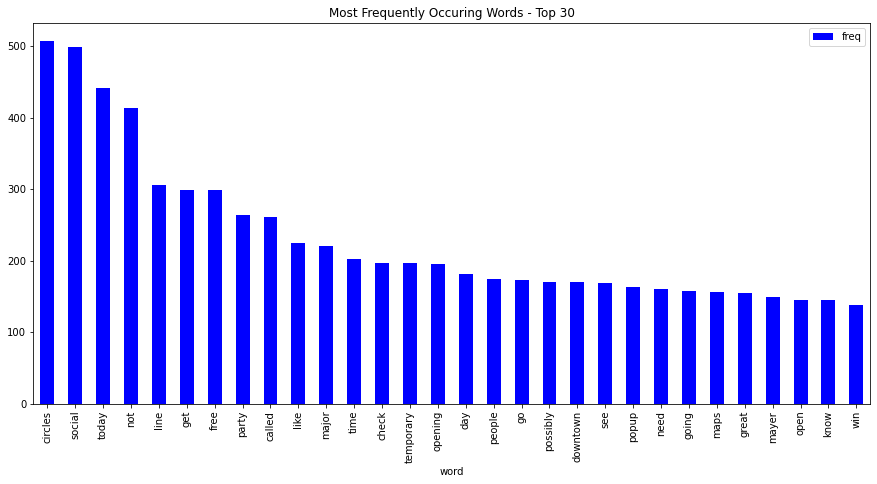

In [972]:
cv = CountVectorizer(lowercase=False)

words = cv.fit_transform(X_train_clean2)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

In [970]:
more_stopwords.extend(['sxswi', 'one', 'apps'])

In [760]:
 models[0][1][2]

MultinomialNB()

In [775]:
params_mba1 = {'MultinomialNB': [{
    'classifier__alpha':[.001, .01, .05, .1, .2, .4, .6, .8, 1]
}]}

run_gridsearch(params_mba1, name='MultinomialNB', models=models4, num=num_mba)

MultinomialNB Grid Search:
Time Started: Wed Feb 16 13:00:27 2022
MultinomialNB
Time Finished: Wed Feb 16 13:00:33 2022
Cross validation scores: [0.6681844  0.67215348 0.67803291 0.68023912 0.67994511 0.67832811
 0.67230032 0.66465596 0.66127545]
Best cross validation score: 68.02%
Optimal parameters: {'classifier__alpha': 0.1}


In [776]:
params_lr1 = {'LogisticRegression': [{
    'classifier__C':[0.001, 0.1, 1],
    'classifier__solver':['lbfgs', 'saga'],
    'classifier__fit_intercept':[True, False]
}]}

run_gridsearch(params_lr1, name='LogisticRegression1', models=models4, num=num_lreg)

LogisticRegression Grid Search:
Time Started: Wed Feb 16 13:00:33 2022
LogisticRegression
Time Finished: Wed Feb 16 13:00:52 2022
Cross validation scores: [0.60982063 0.60982063 0.61026159 0.61026159 0.6431924  0.6431924
 0.65701215 0.65701215 0.69420625 0.69420625 0.69729254 0.69729254]
Best cross validation score: 69.73%
Optimal parameters: {'classifier__C': 1, 'classifier__fit_intercept': False, 'classifier__solver': 'lbfgs'}


In [778]:
params_dtc1 = {'DecisionTree': [{
    'classifier__criterion':['gini', 'entropy'],
    'classifier__max_depth':[1, 2, 6, 10, 15],
    'classifier__ccp_alpha':[.001, .01, .1, .5]
}]}

run_gridsearch(params_dtc1, name='DecisionTree1', models=models4, num=num_dtc)

DecisionTree Grid Search:
Time Started: Wed Feb 16 13:07:27 2022
DecisionTree
Time Finished: Wed Feb 16 13:08:03 2022
Cross validation scores: [0.61570299 0.62172797 0.63157734 0.63290001 0.6336353  0.60982063
 0.62011119 0.63510654 0.63451787 0.63348652 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.61893558 0.61893558
 0.61893558 0.61893558 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063]
Best cross validation score: 63.51%
Optimal parameters: {'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'entropy', 'classifier__max_depth': 6}


In [551]:
params_rf1 = {'RandomForest': [{
    'classifier__n_estimators':[10, 30, 100],
    'classifier__criterion':['gini', 'entropy'],
    'classifier__max_depth':[1, 2, 6, 10],
}]}

run_gridsearch(params_rf1, name='RandomForest1', models=models4, num=num_rfc)

RandomForest Grid Search:
Time Started: Tue Feb 15 19:38:08 2022
RandomForest
Time Finished: Tue Feb 15 19:38:35 2022
Cross validation scores: [0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.61378993 0.6129079  0.61276095 0.61952349 0.61643644 0.61570137
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.61217336 0.6112909  0.61246683 0.61481999 0.61481934 0.61437848]
Best cross validation score: 61.95%
Optimal parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 10}


Takes a long time to run:

In [884]:
params_gbc1 = {'GradBoostClassifier': [{
    'classifier__learning_rate':[.001, .01],
    'classifier__n_estimators':[100, 200],
    'classifier__max_depth':[5, 10]
}]}

run_gridsearch(params_gbc1, name='GradBoostClassifier1', models=models4, num=num_gbc)

GradBoostClassifier Grid Search:
Time Started: Wed Feb 16 15:12:21 2022
GradBoostClassifier


D:\ProgramFilesD\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramFilesD\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramFilesD\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\ProgramFilesD\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "D:\ProgramFilesD\Anacond

Time Finished: Wed Feb 16 15:31:47 2022
Cross validation scores: [0.60982063 0.61187946 0.60982063 0.62216979        nan        nan
        nan        nan 0.64466277 0.65833492 0.65686368 0.66862482
        nan        nan        nan        nan]
Best cross validation score: 66.86%
Optimal parameters: {'classifier__learning_rate': 0.01, 'classifier__loss': 'deviance', 'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [997]:
params_svc1 = {'SVC': [{
    'classifier__C':[1],
    'classifier__kernel':['linear'],
    'classifier__gamma':['scale'],
}]}

run_gridsearch(params_svc1, name='SVC1', models=models4, num=num_svc)

SVC Grid Search:
Time Started: Thu Feb 17 16:20:22 2022
SVC


ValueError: Found input variables with inconsistent numbers of samples: [6802, 6803]

In [887]:
from gensim.models import Word2Vec
from nltk import word_tokenize

In [888]:
X_train_w2v = X_train_clean.map(word_tokenize)

w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

In [891]:
w2v_model

In [893]:
import gensim

In [898]:
model_w2v = gensim.models.Word2Vec(
            sentences=X_train_clean,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(X_train_clean, total_examples=len(X_train_clean), epochs=20)

(1759653, 9577000)

In [900]:
import numpy as np

In [899]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [903]:
wordvec_arrays = np.zeros((len(X_train_clean), 100))

for i in range(3):
    wordvec_arrays[i,:] = word_vector(X_train_clean[i], 100)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape   

(6802, 100)

In [904]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.071878,-0.019560,-0.011142,0.195084,-0.078798,0.075288,0.109781,-0.026607,-0.103091,0.020901,...,-0.119118,-0.018613,0.013605,-0.049725,0.004617,0.014182,-0.014896,0.071967,-0.010115,-0.080846
1,-0.070854,-0.016538,-0.028604,0.181693,-0.083319,0.082060,0.121326,-0.032100,-0.103172,0.019556,...,-0.116595,-0.013997,0.007265,-0.051047,-0.001095,0.006704,0.000819,0.072577,-0.008035,-0.068324
2,-0.073431,-0.000472,-0.009451,0.202837,-0.089211,0.081259,0.117634,-0.038893,-0.129476,0.033161,...,-0.120522,-0.014114,0.000669,-0.039683,-0.007416,0.002261,-0.011071,0.069871,-0.016671,-0.048326
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [905]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, 
                                                    y_train_clean, 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [906]:
rfc = RandomForestClassifier(n_estimators=500, criterion='gini', verbose=1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy 0.6119929453262787


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


In [908]:
from sklearn.linear_model import SGDClassifier

In [909]:
clf = SGDClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6119929453262787


In [911]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [912]:
tokenizer = RegexpTokenizer(pattern=r"(?u)\b\w\w+\b")

sw = stopwords.words('english')

lemmatizer = WordNetLemmatizer() 

In [913]:
def tokenize_tweet(text, tokenizer, stopwords_list, lemmatizer):
        
    text = tokenizer.tokenize(text)
    text = [token for token in text if token not in stopwords_list]
    text = [lemmatizer.lemmatize(token) for token in text]

    return text

In [920]:
def clean_and_tokenize_tweets(df):
    df.rename(columns={'tweet_text': 'text', 
                'is_there_an_emotion_directed_at_a_brand_or_product': 'target'}, 
                inplace=True)
    
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2,
                                     'I can\'t tell': 0})    
    
    df['text'] = df['text'].str.lower()

    df['text'] = df['text'].apply(lambda x: tokenize_tweet(x, tokenizer, sw, lemmatizer))

    return df

In [921]:
clean_and_tokenize_tweets(df2)

TypeError: expected string or bytes-like object

In [409]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

def print_cm_with_labels(y_true, 
                         y_pred, 
                         display_labels):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(display_labels,rotation=45);

In [258]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

In [280]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

Changing target to numeral:

In [129]:
# df['target'] = df['target'].map({'No emotion toward brand or product': 0,
#                                      'Negative emotion': 1,
#                                      'Positive emotion': 2})

In [130]:
df.head()

,text,product,target,length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17


In [131]:
from nltk.tokenize import RegexpTokenizer

In [132]:
regex_token = RegexpTokenizer(r"\w+")

In [137]:
new_pos_text = df['text'].loc[df['target'] == 'Positive emotion'].tolist()
new_pos_text = ' '.join(new_pos_text).lower()
new_pos_text = regex_token.tokenize(new_pos_text)

new_neg_text = df['text'].loc[df['target'] == 'Negative emotion'].tolist()
new_neg_text = ' '.join(new_neg_text).lower()
new_neg_text = regex_token.tokenize(new_neg_text)


new_neut_text = df['text'].loc[df['target'] == 'No emotion toward brand or product'].tolist()
new_neut_text = ' '.join(new_neut_text).lower()
new_neut_text = regex_token.tokenize(new_neut_text)

unique_neg = set(new_neg_text)
unique_pos = set(new_pos_text)
unique_neut = set(new_neut_text)


only_pos= unique_pos.difference(unique_neut.union(unique_neg))
only_pos = ' '.join(only_pos)

only_neg= unique_neg.difference(unique_pos.union(unique_neut))
only_neg = ' '.join(only_neg)

only_neut= unique_neut.difference(unique_pos.union(unique_neg))
only_neut = ' '.join(only_neut)

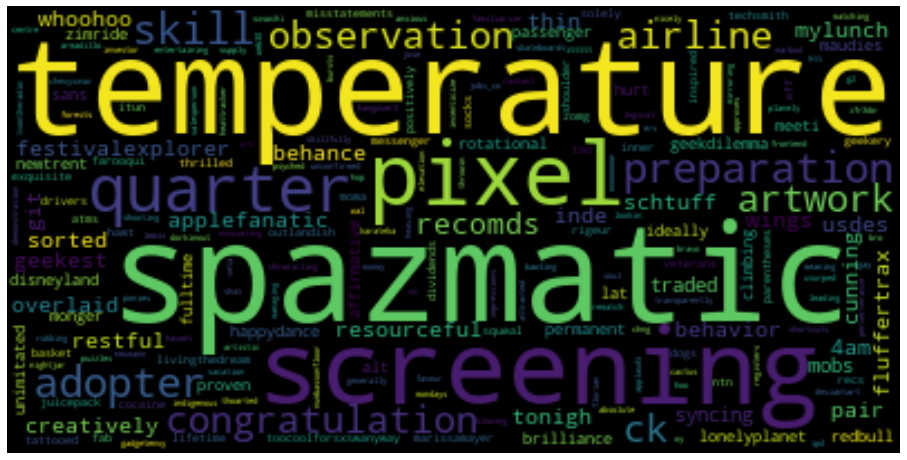

In [138]:
wordcloud = WordCloud().generate(only_pos)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

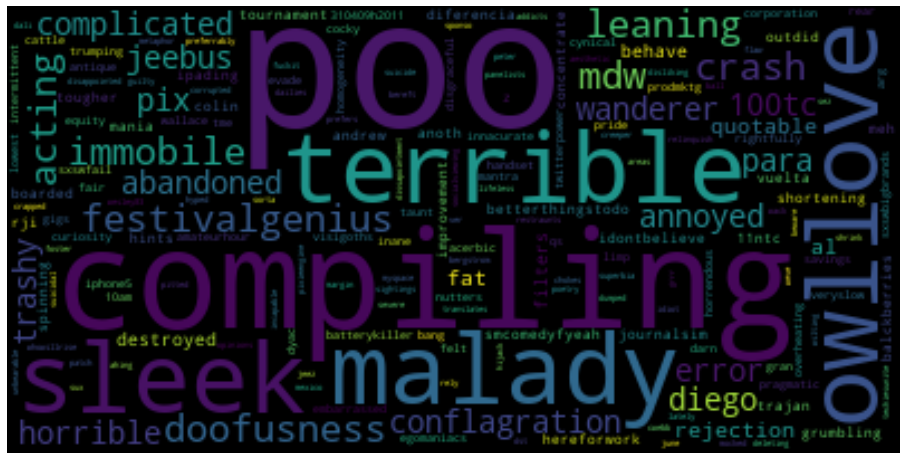

In [139]:
wordcloud = WordCloud().generate(only_neg)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

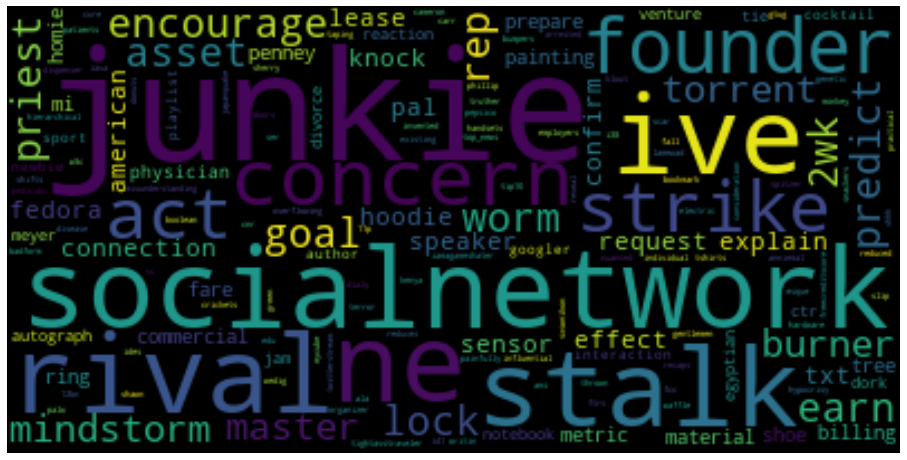

In [140]:
wordcloud = WordCloud().generate(only_neut)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [878]:
df.iloc[2:6]

,text,product,target,length
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,18


In [851]:
df_sample = df.iloc[2:6]
df_sample2 = df.loc[9092]
df_sample = df_sample.append(df_sample2)

In [852]:
df_sample['text']

2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
5       @teachntech00 New iPad Apps For #SpeechTherapy...
9092    �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...
Name: text, dtype: object

In [853]:
for i in df_sample['text']:
    print(i)

@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
�ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mention Google Tests ���Check-in Offers�۝ At #SXSW {link}


In [854]:
df_sample['text'] = df_sample['text'].apply(lambda x: x.lower())

In [855]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd
�ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���rt @mention google tests ���check-in offers�۝ at #sxsw {link}


In [856]:
df_sample['text'] = df_sample['text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [857]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd
___rt @mention google tests check-in offers at #sxsw {link}


In [858]:
df_sample['text'] = df_sample['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [859]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd
___rt @mention google tests check-in offers at #sxsw {link}


In [860]:
df_sample['text'] = df_sample['text'].apply(lambda x: re.sub(r'@\S*', '', x))

In [861]:
for i in df_sample['text']:
    print(i)

 can not wait for #ipad 2 also. they should sale them down at #sxsw.
 i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
 great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd
___rt  google tests check-in offers at #sxsw {link}


In [862]:
df_sample['text'] = df_sample['text'].apply(lambda x: tokenize_row(x))

In [863]:
for i in df_sample['text']:
    print(i)

['', 'can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw', '']
['', 'i', 'hope', 'this', 'year', 's', 'festival', 'isn', 't', 'as', 'crashy', 'as', 'this', 'year', 's', 'iphone', 'app', 'sxsw']
['', 'great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'o', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress', '']
['', 'new', 'ipad', 'apps', 'for', 'speechtherapy', 'and', 'communication', 'are', 'showcased', 'at', 'the', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['___rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link', '']


In [864]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_punctuation_row(x))

In [865]:
for i in df_sample['text']:
    print(i)

['can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw']
['i', 'hope', 'this', 'year', 's', 'festival', 'isn', 't', 'as', 'crashy', 'as', 'this', 'year', 's', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'o', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'for', 'speechtherapy', 'and', 'communication', 'are', 'showcased', 'at', 'the', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link']


In [866]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_stopwords_row(x))

In [867]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'also', 'sale', 'sxsw']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['google', 'tests', 'check', 'offers', 'sxsw', 'link']


In [868]:
df_sample['text'] = df_sample['text'].apply(lambda x: lem_row(x))

In [869]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'also', 'sale', 'sxsw']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'book', 'conference', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['google', 'test', 'check', 'offer', 'sxsw', 'link']


In [870]:
more_stop_words_r = ['link', 'also', 'sxsw', 'amp', ]

In [873]:
def remove_stopwords_row2(text):
    text=[word for word in text if word not in more_stop_words_r]
    return text

In [874]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_stopwords_row2(x))

In [875]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'sale']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app']
['great', 'stuff', 'fri', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'book', 'conference', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'conference', 'iear', 'edchat', 'asd']
['google', 'test', 'check', 'offer']


In [876]:
df_sample['text'] = df_sample['text'].apply(lambda x: ' '.join(x))

In [877]:
for i in df_sample['text']:
    print(i)

not wait ipad 2 sale
hope year festival crashy year iphone app
great stuff fri marissa mayer google tim reilly tech book conference matt mullenweg wordpress
new ipad apps speechtherapy communication showcased conference iear edchat asd
google test check offer


## Cleaning the text column

In [18]:
df_changed = df.copy()

#### Lower casing:

In [19]:
df_changed['text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [20]:
df_changed['text'] = df_changed['text'].apply(lambda x: x.lower())

In [21]:
df_changed['text'][0]

'.@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.'

#### Removing non-ascii:

In [22]:
def remove_non_ascii(text):
    return unidecode(unicode(text, encoding = "utf-8"))

In [23]:
df_changed['text'][9092]

'�ϡ�����_��ʋ�\u038b�ҋ�������⋁_��������_���rt @mention google tests ���check-in offers�\u06dd at #sxsw {link}'

In [24]:
df_changed['text'] = df_changed['text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [25]:
df_changed['text'][9092]

'___rt @mention google tests check-in offers at #sxsw {link}'

#### Removing urls:

In [26]:
df_changed['text'][5]

'@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd'

In [27]:
df_changed['text'] = df_changed['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [28]:
df_changed['text'][5]

'@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd'

#### Removing user tagging:

In [29]:
df_changed['text'][5]

'@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd'

In [30]:
df_changed['text'] = df_changed['text'].apply(lambda x: re.sub(r'@\S*', '', x))

In [31]:
df_changed['text'][4]

" great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)"

#### Tokeninzing:

In [835]:
def tokenize_row(text):
    split=re.split("\W+",text) 
    return split

In [33]:
df_changed['text'] = df_changed['text'].apply(lambda x: tokenize(x))

In [34]:
df_changed.head()

,text,product,target,length
0,"[, i, have, a, 3g, iphone, after, 3, hrs, twee...",iPhone,1,23
1,"[, know, about, awesome, ipad, iphone, app, th...",iPad or iPhone App,2,22
2,"[, can, not, wait, for, ipad, 2, also, they, s...",iPad,2,15
3,"[, i, hope, this, year, s, festival, isn, t, a...",iPad or iPhone App,1,15
4,"[, great, stuff, on, fri, sxsw, marissa, mayer...",Google,2,17


#### Remove punctuation and empty indexes:

In [35]:
df_changed['text'][9092]

['___rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link', '']

In [838]:
def remove_punctuation_row(tokens):
    token_list = [''.join(letter for letter in word if letter not in string.punctuation) for word in tokens]
    return [word for word in token_list if word]

In [37]:
df_changed['text'] = df_changed['text'].apply(lambda x: remove_punctuation(x))

In [38]:
df_changed['text'][9092]

['rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link']

#### Removing stopwords:

In [39]:
stopword = nltk.corpus.stopwords.words('english')

In [40]:
stopword.remove('not')

In [41]:
stopword.append('rt')

In [841]:
def remove_stopwords_row(text):
    text=[word for word in text if word not in stopword]
    return text

In [43]:
df_changed['text'][9092]

['rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link']

In [44]:
df_changed['text'] = df_changed['text'].apply(lambda x: remove_stopwords(x))

In [45]:
df_changed['text'][9092]

['google', 'tests', 'check', 'offers', 'sxsw', 'link']

In [46]:
df_changed

,text,product,target,length
0,"[3g, iphone, 3, hrs, tweeting, riseaustin, dea...",iPhone,1,23
1,"[know, awesome, ipad, iphone, app, likely, app...",iPad or iPhone App,2,22
2,"[not, wait, ipad, 2, also, sale, sxsw]",iPad,2,15
3,"[hope, year, festival, crashy, year, iphone, a...",iPad or iPhone App,1,15
4,"[great, stuff, fri, sxsw, marissa, mayer, goog...",Google,2,17
...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",iPad,2,4
9089,"[wave, buzz, interrupt, regularly, scheduled, ...",NaN,0,18
9090,"[google, zeiger, physician, never, reported, p...",NaN,0,19
9091,"[verizon, iphone, customers, complained, time,...",NaN,0,23


### Lemmetizing:

In [57]:
stemmer = PorterStemmer()

In [845]:
def stem(document):
    return [stemmer.stem(token) for token in document]

In [58]:
df_changed['text'].apply(lambda x: stem(x))

0       [3g, iphon, 3, hr, tweet, riseaustin, dead, ne...
1       [know, awesom, ipad, iphon, app, like, appreci...
2                  [not, wait, ipad, 2, also, sale, sxsw]
3       [hope, year, festiv, crashi, year, iphon, app,...
4       [great, stuff, fri, sxsw, marissa, mayer, goog...
                              ...                        
9088                        [ipad, everywher, sxsw, link]
9089    [wave, buzz, interrupt, regularli, schedul, sx...
9090    [googl, zeiger, physician, never, report, pote...
9091    [verizon, iphon, custom, complain, time, fell,...
9092              [googl, test, check, offer, sxsw, link]
Name: text, Length: 9070, dtype: object

The use of a stemmer leads to very unuseful word trimming, like 'googl' and 'iphon'.

In [53]:
lemmatizer = WordNetLemmatizer() 

In [846]:
def lem_row(document):
    return [lemmatizer.lemmatize(token) for token in document]

In [55]:
df_changed['text'].apply(lambda x: lem(x))

0       [3g, iphone, 3, hr, tweeting, riseaustin, dead...
1       [know, awesome, ipad, iphone, app, likely, app...
2                  [not, wait, ipad, 2, also, sale, sxsw]
3       [hope, year, festival, crashy, year, iphone, a...
4       [great, stuff, fri, sxsw, marissa, mayer, goog...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [google, zeiger, physician, never, reported, p...
9091    [verizon, iphone, customer, complained, time, ...
9092             [google, test, check, offer, sxsw, link]
Name: text, Length: 9070, dtype: object

In [59]:
df_changed['text'] = df_changed['text'].apply(lambda x: lem(x))

In [60]:
df_changed

,text,product,target,length
0,"[3g, iphone, 3, hr, tweeting, riseaustin, dead...",iPhone,1,23
1,"[know, awesome, ipad, iphone, app, likely, app...",iPad or iPhone App,2,22
2,"[not, wait, ipad, 2, also, sale, sxsw]",iPad,2,15
3,"[hope, year, festival, crashy, year, iphone, a...",iPad or iPhone App,1,15
4,"[great, stuff, fri, sxsw, marissa, mayer, goog...",Google,2,17
...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",iPad,2,4
9089,"[wave, buzz, interrupt, regularly, scheduled, ...",NaN,0,18
9090,"[google, zeiger, physician, never, reported, p...",NaN,0,19
9091,"[verizon, iphone, customer, complained, time, ...",NaN,0,23


# Vectorizing

In [143]:
df_clean = df_changed.copy()

In [142]:
from sklearn.feature_extraction.text import CountVectorizer

In [161]:
df_clean['text'] = df_clean['text'].apply(lambda x: ' '.join(x))

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

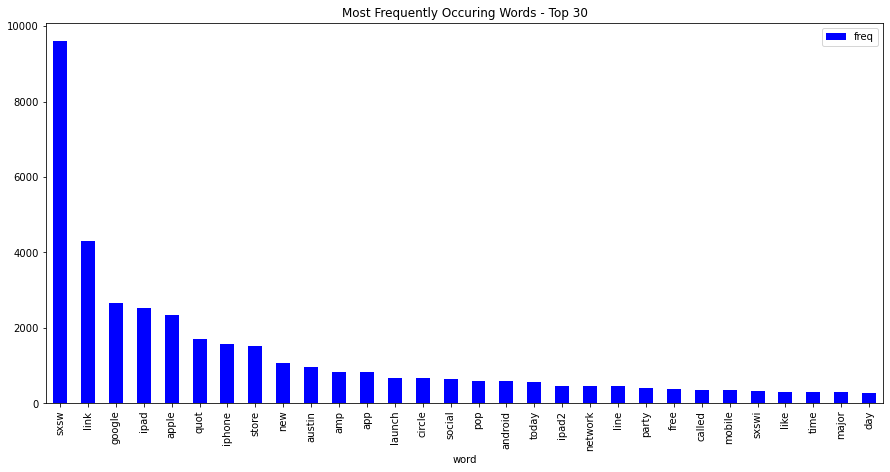

In [165]:
cv = CountVectorizer(stop_words = 'english', lowercase=False)

words = cv.fit_transform(df_clean.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

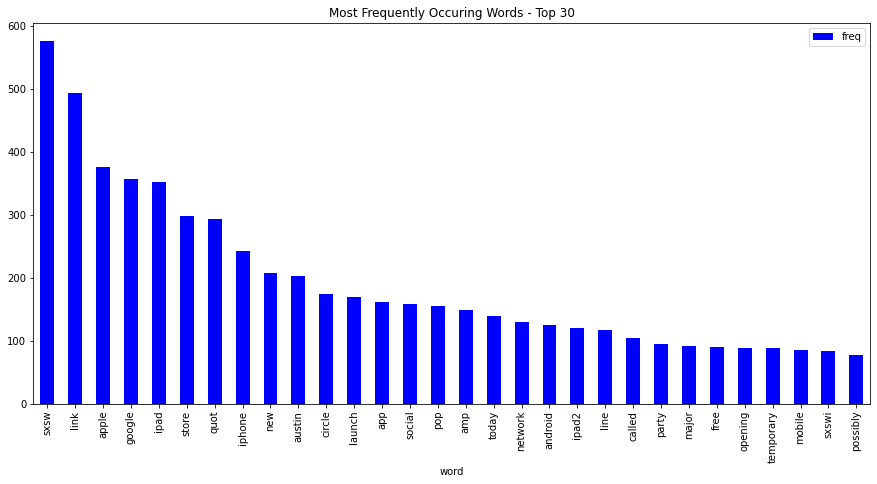

In [167]:
tfidf = TfidfVectorizer(stop_words = 'english', lowercase=False)

words = tfidf.fit_transform(df_clean.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

In [170]:
even_more_sw = ['sxsw', 'link', 'apple', 'ipad', 'google', 'store', 'quot', 'iphone', 'austin', 'app', 'ipad2', 'android', 'pop', 'amp']

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

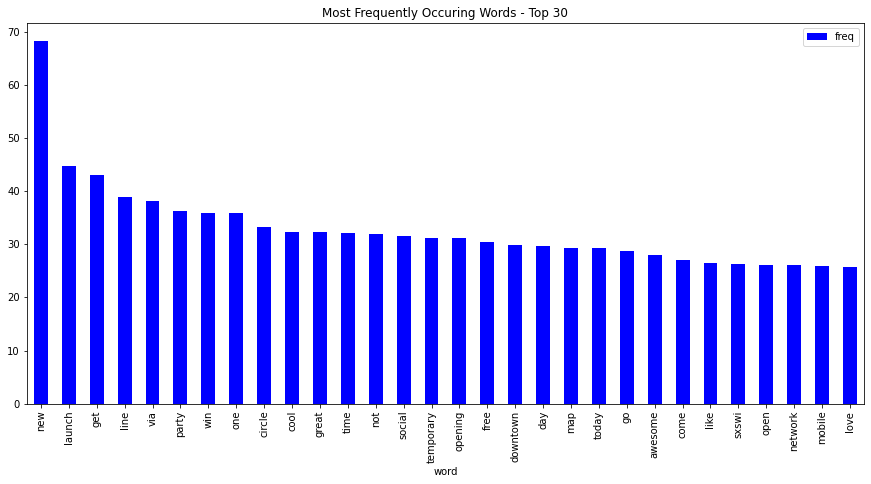

In [305]:
tfidf = TfidfVectorizer(stop_words=even_more_sw, lowercase=False)

words = tfidf.fit_transform(df_clean[df_clean['target']==2]['text'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

### Generating Wordclouds

In [74]:
' '.join(df_changed.text[0])

'3g iphone 3 hr tweeting riseaustin dead need upgrade plugin station sxsw'

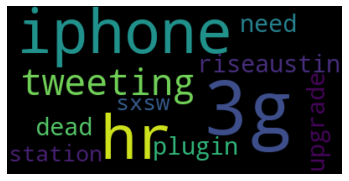

In [72]:
# Start with one review:
text = ' '.join(df_changed.text[0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
df_good = df_changed.copy()

In [90]:
df_good = df_good[df_good['target']==2]

In [91]:
df_good

,text,product,target,length
1,"[know, awesome, ipad, iphone, app, likely, app...",iPad or iPhone App,2,22
2,"[not, wait, ipad, 2, also, sale, sxsw]",iPad,2,15
4,"[great, stuff, fri, sxsw, marissa, mayer, goog...",Google,2,17
7,"[sxsw, starting, ctia, around, corner, googlei...",Android,2,28
8,"[beautifully, smart, simple, idea, wrote, holl...",iPad or iPhone App,2,17
...,...,...,...,...
9072,"[iphone, 4, case, rad, ready, stop, tomorrow, ...",iPhone,2,19
9077,"[pr, guy, convinced, switch, back, iphone, gre...",iPhone,2,16
9079,"[quot, papyrus, sort, like, ipad, quot, nice, ...",iPad,2,10
9085,"[always, used, camera, iphone, b, c, image, st...",iPad or iPhone App,2,25


In [92]:
text = ' '.join(' '.join(review) for review in df_good['text'])

In [93]:
len(text)

207661

In [97]:
more_stopwords = ['sxsw','sxswi', 'link', 'quot']

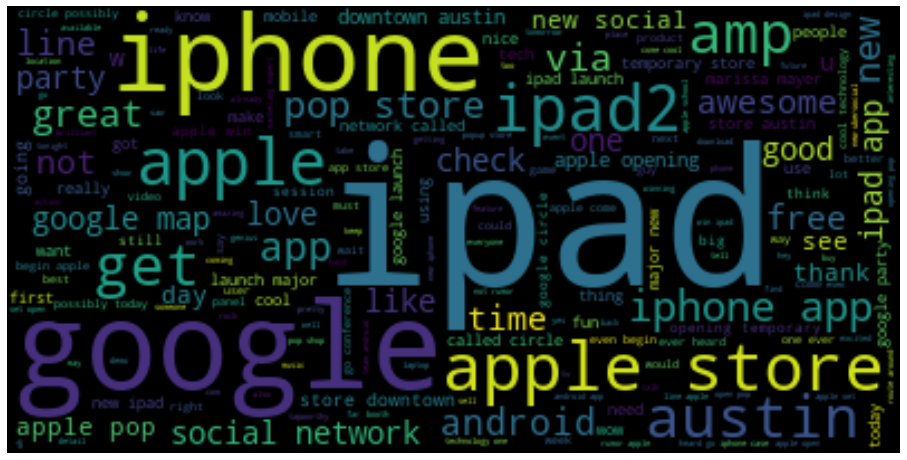

In [100]:
wordcloud = WordCloud(stopwords=more_stopwords).generate(text)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [101]:
df_bad = df_changed.copy()

In [102]:
df_bad = df_bad[df_bad['target']==1]

In [103]:
text = ' '.join(' '.join(review) for review in df_bad['text'])

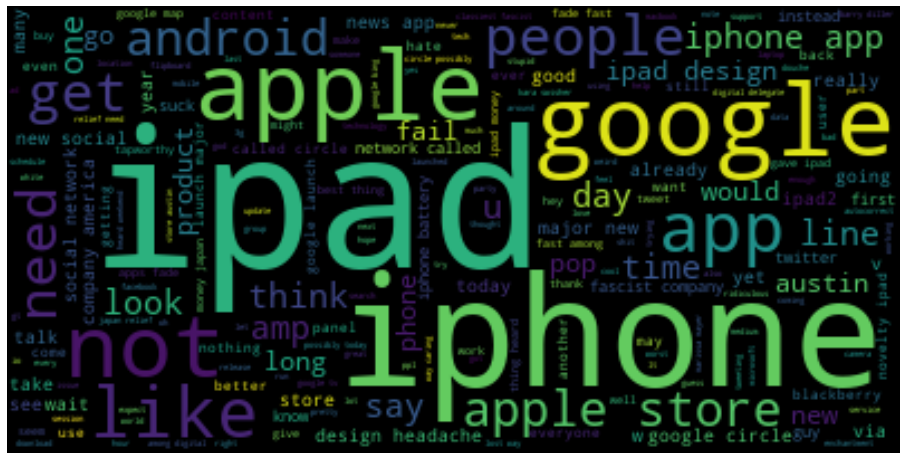

In [104]:
wordcloud = WordCloud(stopwords=more_stopwords).generate(text)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()